(sec:othello-agent)=
# オセロAIの作成

In [70]:
%load_ext autoreload
%autoreload 2
import numpy as np
from othello.env import Env, Move, Player

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
env = Env()
player, _ = env.reset()

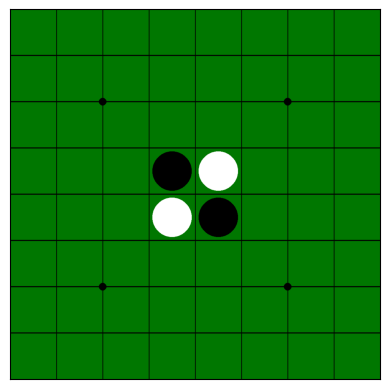

In [72]:
env

In [73]:
moves = env.legal_moves(player)
print(moves)

[('BLACK', 2, 4), ('BLACK', 3, 5), ('BLACK', 4, 2), ('BLACK', 5, 3)]


In [74]:
player, _ = env.step(moves[0])

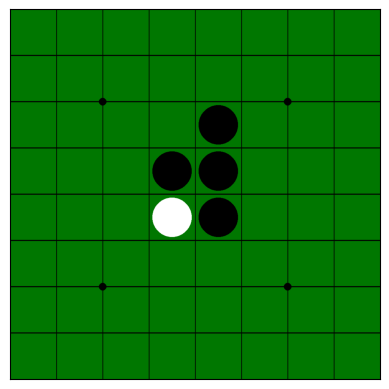

In [75]:
env

In [76]:
while not env.gameset():
    moves = env.legal_moves(player)
    if len(moves) != 0:
        move = np.random.choice(moves)
    else:
        move = Move.Pass(player)
        
    player, _ = env.step(move)

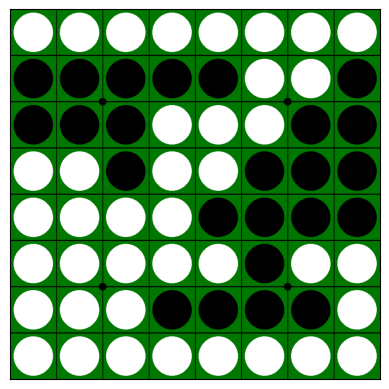

In [77]:
env

In [78]:
env.count()

(24, 40)